# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 37kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

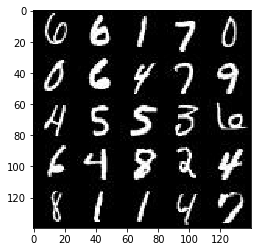

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

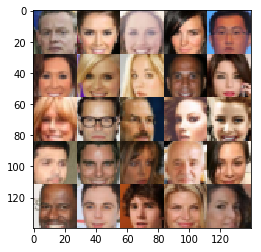

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32,(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse = reuse):
        conv2d_1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv2d_1 = tf.maximum(alpha*conv2d_1, conv2d_1)
        
        conv2d_2 = tf.layers.conv2d(conv2d_1, 112, 5, 2, 'SAME')
        conv2d_2 = tf.layers.batch_normalization(conv2d_2, training = True)
        conv2d_2 = tf.maximum(alpha*conv2d_2, conv2d_2)
        
        conv2d_3 = tf.layers.conv2d(conv2d_2, 224, 5, 2, 'SAME')
        conv2d_3 = tf.layers.batch_normalization(conv2d_3, training = True)
        conv2d_3 = tf.maximum(alpha*conv2d_3, conv2d_3)

        flat = tf.reshape(conv2d_3, (-1, 4 * 4 * 224))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate = 0.5)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        full = tf.layers.dense(z, (7 * 7 * 112))
        full = tf.reshape(full, (-1, 7, 7, 112))
        full = tf.layers.batch_normalization(full, training = is_train)
        full = tf.maximum(alpha * full, full)

        conv2d_1 = tf.layers.conv2d_transpose(full, 56, 5, 2, 'SAME')
        conv2d_1 = tf.layers.batch_normalization(conv2d_1, training = is_train)
        conv2d_1 = tf.maximum(alpha * conv2d_1, conv2d_1)
        
        conv2d_2 = tf.layers.conv2d_transpose(conv2d_1, out_channel_dim, 5, 2, 'SAME')
        output = tf.tanh(conv2d_2)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real, 
            labels = tf.ones_like(disc_logits_real) * 0.8))
    
    disc_loss_fake = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake, 
            labels = tf.zeros_like(disc_logits_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake, 
            labels = tf.ones_like(disc_model_fake)))
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(
            learning_rate, 
            beta1 = beta1).minimize(d_loss, var_list = disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(
            learning_rate, 
            beta1 = beta1).minimize(g_loss, var_list = gen_vars)

    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)

    steps = 0
    print_period = 10
    display_period = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_period == 0:
                    train_loss_disc = disc_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_disc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))

                if steps % display_period == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 1.8135
Epoch 1/2... Discriminator Loss: 2.2944... Generator Loss: 0.2356
Epoch 1/2... Discriminator Loss: 2.1813... Generator Loss: 0.2855
Epoch 1/2... Discriminator Loss: 2.5226... Generator Loss: 0.1787
Epoch 1/2... Discriminator Loss: 2.3570... Generator Loss: 0.2211
Epoch 1/2... Discriminator Loss: 2.1741... Generator Loss: 0.2443
Epoch 1/2... Discriminator Loss: 1.7270... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.9516... Generator Loss: 0.3399
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.7635... Generator Loss: 0.3694


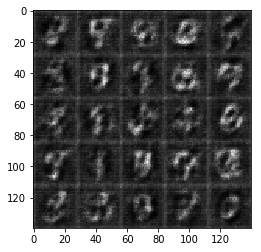

Epoch 1/2... Discriminator Loss: 1.6575... Generator Loss: 0.4091
Epoch 1/2... Discriminator Loss: 1.8044... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.8738... Generator Loss: 0.3474
Epoch 1/2... Discriminator Loss: 1.7993... Generator Loss: 0.3832
Epoch 1/2... Discriminator Loss: 2.0106... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 0.4082
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 2.0580
Epoch 1/2... Discriminator Loss: 1.8152... Generator Loss: 2.2291


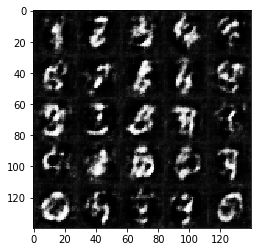

Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 1.5178
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 1.6873
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 2.1645... Generator Loss: 0.2598
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.8136... Generator Loss: 0.3951
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 2.1747
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 1.8087... Generator Loss: 2.8419


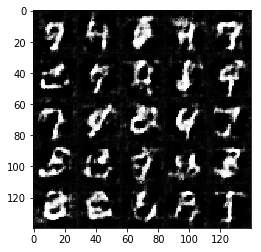

Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.4048
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.5348
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 1.9052
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.5787
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.2544
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 2.4026
Epoch 1/2... Discriminator Loss: 1.8713... Generator Loss: 0.3301


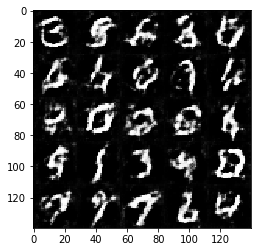

Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.8012... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 1.7577... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 1.3330
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 1.9976
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 1.3918
Epoch 1/2... Discriminator Loss: 1.5614... Generator Loss: 2.2444


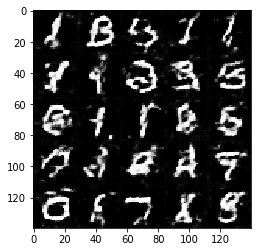

Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 1.6081
Epoch 1/2... Discriminator Loss: 1.9425... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 1.9590... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.7934... Generator Loss: 0.3932
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 2.5734
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.9974
Epoch 1/2... Discriminator Loss: 1.8632... Generator Loss: 0.4171
Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 0.9131


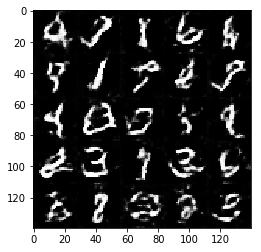

Epoch 1/2... Discriminator Loss: 1.7675... Generator Loss: 0.4065
Epoch 1/2... Discriminator Loss: 1.7971... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 1.6063
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.3336
Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 1.6546... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.2595
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 2.0473


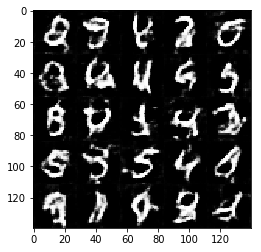

Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 2.0136
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 1.5817
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.9064
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.2595
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 1.5694
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 1.0718


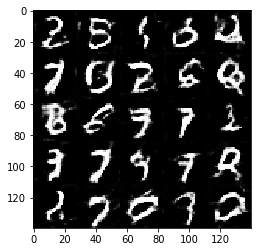

Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 2.0676... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.8668... Generator Loss: 0.3700
Epoch 1/2... Discriminator Loss: 1.8036... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.7339... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.3000
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.8604


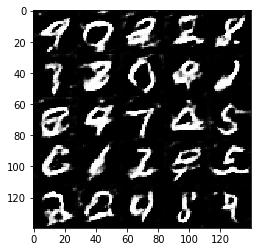

Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 2.9001
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 2.0763
Epoch 1/2... Discriminator Loss: 1.6840... Generator Loss: 2.4055
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.6889... Generator Loss: 2.8815
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 0.8248


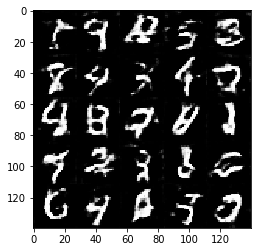

Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 2.1348
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 2.2077
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 1.8394
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 1.4687
Epoch 1/2... Discriminator Loss: 1.8390... Generator Loss: 0.4450
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6864


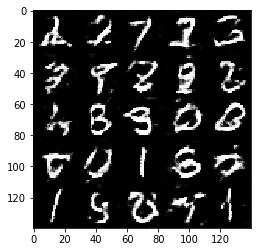

Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 1.2784... Generator Loss: 2.8196
Epoch 1/2... Discriminator Loss: 1.9007... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.8221
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 1.5911... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 2.2830
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 1.8247
Epoch 1/2... Discriminator Loss: 1.7446... Generator Loss: 0.5089


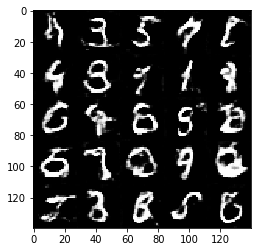

Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.7222... Generator Loss: 3.3266
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 1.8834
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 2.2010... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.3164
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 2.6535
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.4821


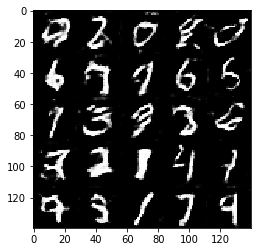

Epoch 1/2... Discriminator Loss: 0.8883... Generator Loss: 1.4720
Epoch 1/2... Discriminator Loss: 2.6657... Generator Loss: 0.2135
Epoch 1/2... Discriminator Loss: 1.6441... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.8951... Generator Loss: 0.4214
Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 1.8464
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 0.8961... Generator Loss: 1.7067
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 2.3679


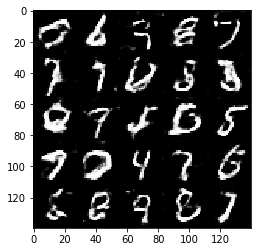

Epoch 1/2... Discriminator Loss: 1.5491... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.8244
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 1.4583
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 1.8740
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.6251... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.7886... Generator Loss: 0.4142
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 0.7934... Generator Loss: 1.6730
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.8358


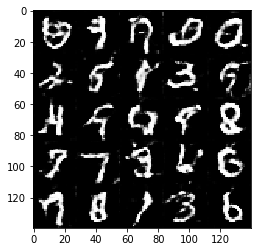

Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.5419
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.9355... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.5804
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.9979
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.6156
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.9132


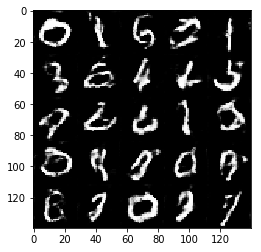

Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 2.2925
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 2.0490
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 1.8288
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.9588
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 2.7224
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 2.4293


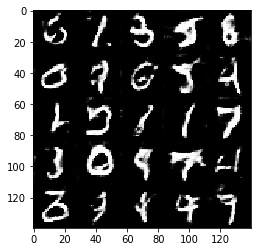

Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 2.2029
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.4085
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 2.3849
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 1.3726
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.9165
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.3367
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.8845


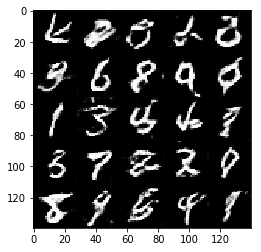

Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 1.7699... Generator Loss: 3.6940
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 1.1205
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.2398
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 1.0052
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.6915


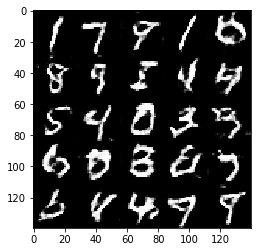

Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.8128
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.4534
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 2.0475
Epoch 2/2... Discriminator Loss: 1.5792... Generator Loss: 3.6288
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.4530
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 1.4073
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 1.5406... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.8251


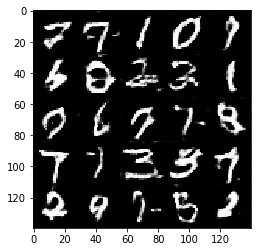

Epoch 2/2... Discriminator Loss: 1.9305... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.3605
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.3839
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.8702
Epoch 2/2... Discriminator Loss: 2.6287... Generator Loss: 0.2652
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 2.1140... Generator Loss: 0.3723
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 2.3185
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7514


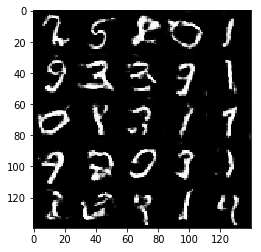

Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.2702
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 2.2681
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.6246... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 2.1656
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.8683
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.4502


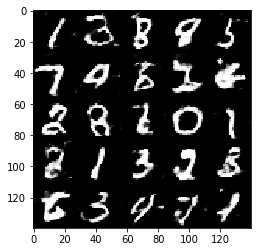

Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 2.4606
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.2045
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 1.2835
Epoch 2/2... Discriminator Loss: 2.1732... Generator Loss: 0.3263
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 2.0626
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 2.1884
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 1.5670... Generator Loss: 0.5756


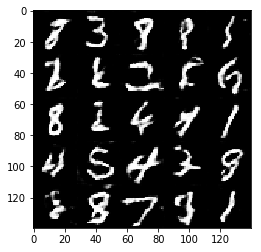

Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 2.3346
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 2.0282
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.6952
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 2.1885
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.4150
Epoch 2/2... Discriminator Loss: 1.4722... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 2.1874
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 3.1812
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.7750


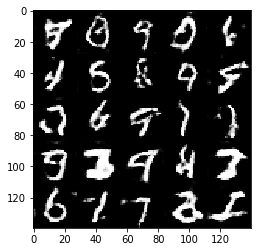

Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 0.7466... Generator Loss: 1.7045
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 1.2492
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 2.3445
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.3423
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 2.3949
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.4240
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.7492
Epoch 2/2... Discriminator Loss: 1.8452... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 1.1066


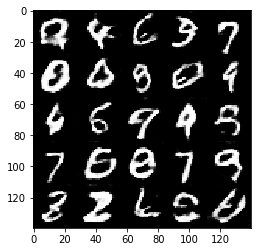

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 3.0034
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 1.4472
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 1.1538
Epoch 2/2... Discriminator Loss: 1.5903... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.4079
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 2.8188
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.9640
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 0.8239


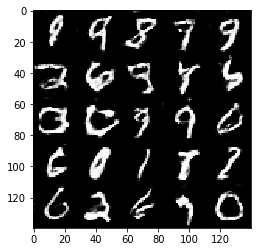

Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.9726
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.7045
Epoch 2/2... Discriminator Loss: 2.1812... Generator Loss: 0.4295
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 2.4845
Epoch 2/2... Discriminator Loss: 1.6756... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.6024
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 2.3212
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 2.9720
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 2.5820
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.8454


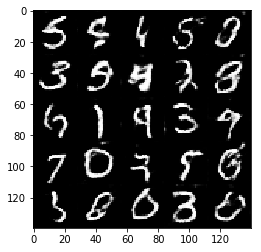

Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.8440
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 1.0543
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 2.2180
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 2.0211
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 1.8970
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 2.0723... Generator Loss: 0.3425


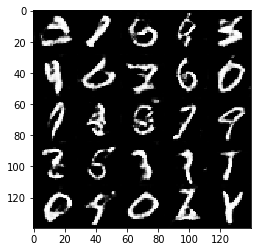

Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.8448
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 3.0244
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 0.6265... Generator Loss: 2.3737
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 2.6999
Epoch 2/2... Discriminator Loss: 1.5245... Generator Loss: 3.2184
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.0842
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.7802


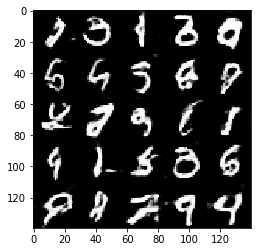

Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 2.0429
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 2.9361
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 2.1825
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.6677


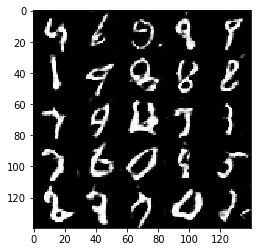

Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.7220
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 2.4617
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.6313
Epoch 2/2... Discriminator Loss: 1.5891... Generator Loss: 3.4792
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.5581


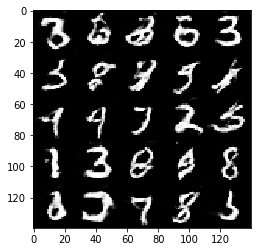

Epoch 2/2... Discriminator Loss: 1.5954... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.9198
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.6768
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 2.3321
Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 2.2718
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 2.6713
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.8727


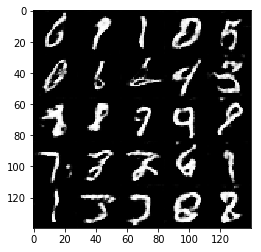

Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.7628
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 2.5551
Epoch 2/2... Discriminator Loss: 1.5656... Generator Loss: 0.5564
Epoch 2/2... Discriminator Loss: 2.1495... Generator Loss: 0.3669
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 2.4637
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 3.9027
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.6084


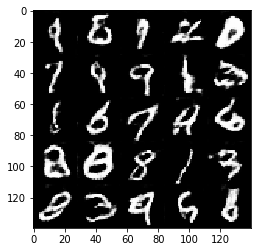

Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.7952
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.9660
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 1.1649
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.9082... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.4127... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 0.6719... Generator Loss: 2.1310
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.7998
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 2.1100


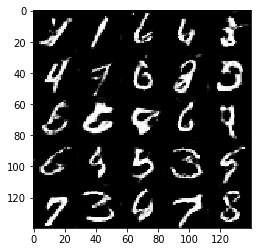

Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.5487
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 1.7225
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 2.3423
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 2.0760
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 2.3670
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 2.7375
Epoch 2/2... Discriminator Loss: 1.6708... Generator Loss: 3.3296
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.5903


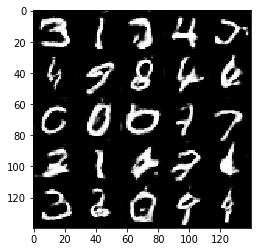

Epoch 2/2... Discriminator Loss: 1.7001... Generator Loss: 0.5542
Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 2.0066
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 2.5132
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 2.3128
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 2.2193
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.7494
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 2.2539
Epoch 2/2... Discriminator Loss: 1.6769... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 1.6664
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.3556


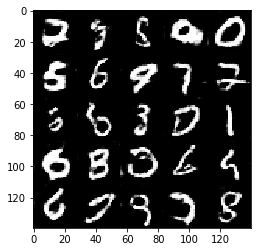

Epoch 2/2... Discriminator Loss: 1.6895... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.8614
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.9782
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 1.7812... Generator Loss: 4.1503
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 2.1969
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.5467


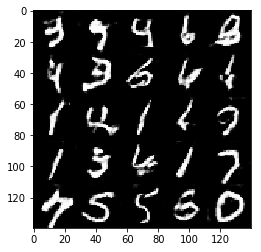

Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 2.7845
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 3.0150
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.4227
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 1.7605
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 1.0114


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.4191... Generator Loss: 13.9449
Epoch 1/1... Discriminator Loss: 2.6513... Generator Loss: 4.0021
Epoch 1/1... Discriminator Loss: 1.8757... Generator Loss: 2.7403
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.9594... Generator Loss: 3.1948
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 1.8426... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6344


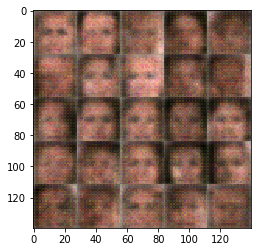

Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.6368
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.0727


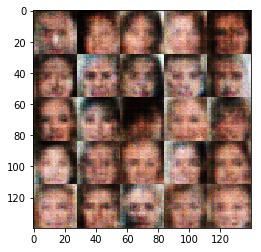

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6846


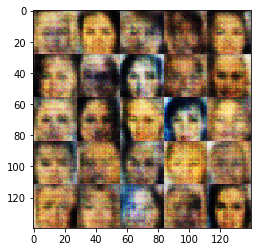

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 2.0194... Generator Loss: 0.2929
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 2.2581... Generator Loss: 2.3781
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.9309


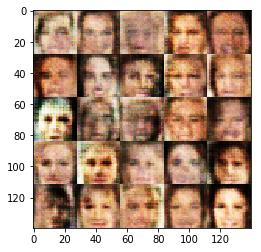

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 1.1669


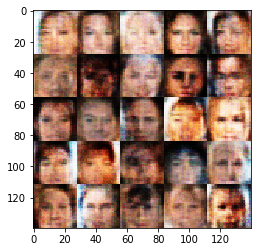

Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 2.3837... Generator Loss: 2.5818
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 2.2227
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.1856


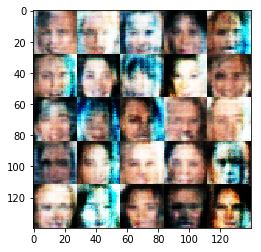

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 2.1440
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 2.4042


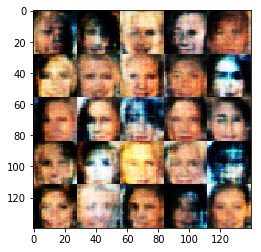

Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.6529
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7995


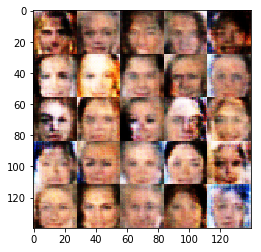

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 3.4394
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.8874
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9417


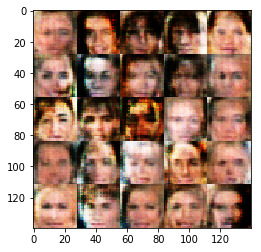

Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 2.5510
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 2.0779
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.7852
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 2.7793
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.1975


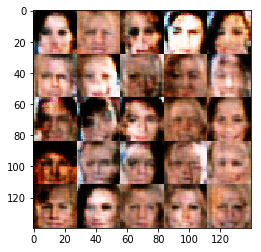

Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 2.3380
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 1.2514


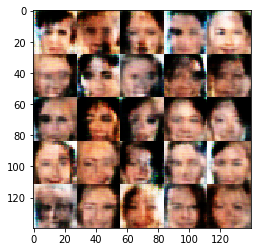

Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 2.2799
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 2.9650
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 2.3093
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 2.3360
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 1.0436


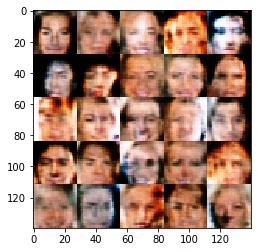

Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.7156
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8337


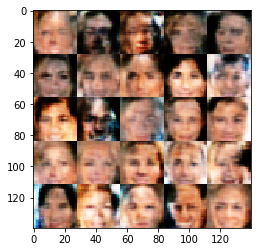

Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.5963
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.4418
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 2.7007
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.3536


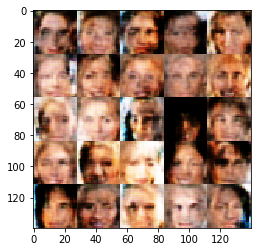

Epoch 1/1... Discriminator Loss: 3.3923... Generator Loss: 4.2969
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 2.3469
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.9498


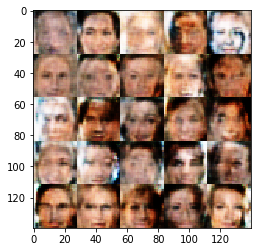

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.7637
Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 2.1814... Generator Loss: 4.5620
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 3.5215
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.5173


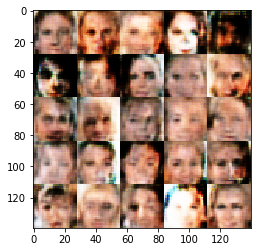

Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 2.3316
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.6877
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.8681


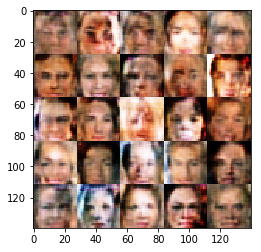

Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.0584
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 3.7998
Epoch 1/1... Discriminator Loss: 2.7307... Generator Loss: 3.3811
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.2167


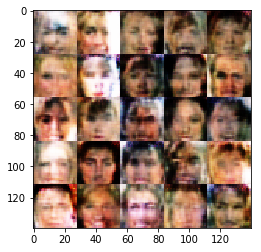

Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.4869
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 2.4161
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 2.4954
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.2314
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 2.4653
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 2.8709


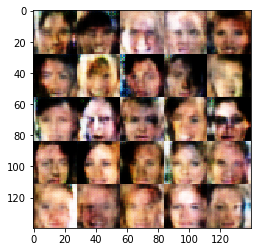

Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 2.3446
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 2.1635
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7464


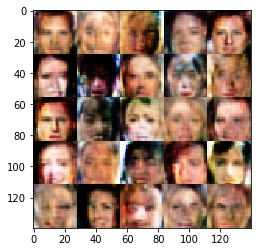

Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 2.6087... Generator Loss: 2.7061
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.7617
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.5988


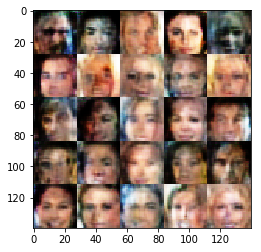

Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.6274
Epoch 1/1... Discriminator Loss: 1.8478... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 2.6954
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.3534
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 2.7621
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.8699
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 2.2899
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 2.3260


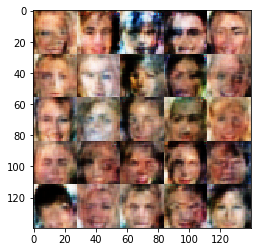

Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 2.5909
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.4595
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 2.3276
Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 2.0045
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.2684
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 2.1122
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.0554


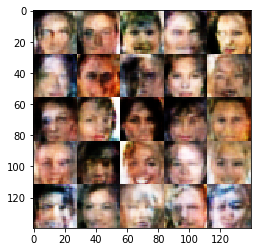

Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.4421
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 1.8844... Generator Loss: 2.6400
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.5452


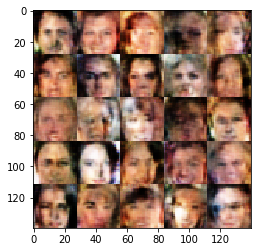

Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.9592
Epoch 1/1... Discriminator Loss: 1.9417... Generator Loss: 0.3619
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 2.1776
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 2.3902
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.4964


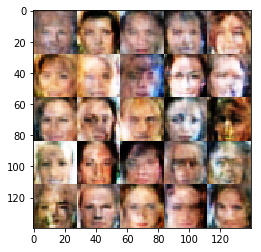

Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.8674
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 1.9417
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.4777
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 1.9405... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 2.1916


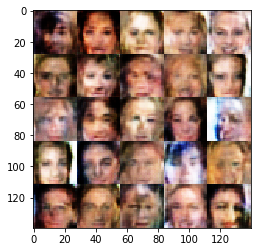

Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 2.6932
Epoch 1/1... Discriminator Loss: 2.4898... Generator Loss: 0.3060
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.1882
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 2.2859... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8550


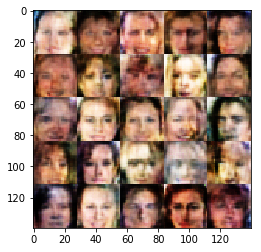

Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.0184
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 2.7656
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.7434
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8041


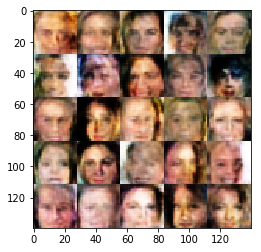

Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 2.0455
Epoch 1/1... Discriminator Loss: 2.0410... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 2.1132
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 2.3779
Epoch 1/1... Discriminator Loss: 1.8395... Generator Loss: 3.6285
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 3.5138


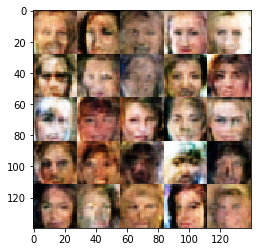

Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 2.3989
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 3.2696
Epoch 1/1... Discriminator Loss: 2.4794... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 2.3760
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 2.1516
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 2.3104
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 2.7423


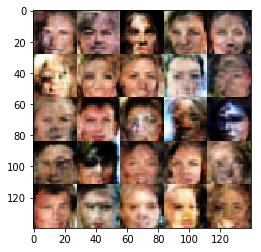

Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 2.9432
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 2.3049
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 2.8493
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 2.3680
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.4976
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.6458


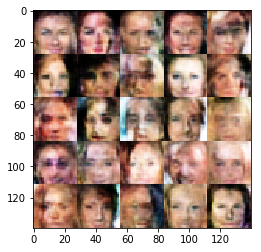

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 3.1794
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 3.2128


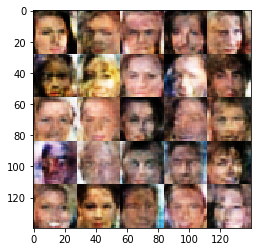

Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 2.1753
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 2.5420
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 2.4620
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 2.7878
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.9159
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 2.7179


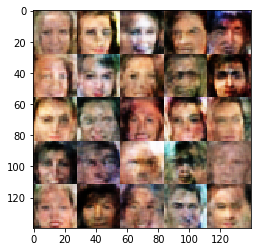

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 2.0547
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.7018
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.9814
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 3.3649
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 2.3755
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.6140


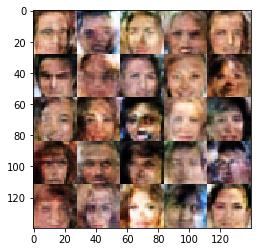

Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 2.8102
Epoch 1/1... Discriminator Loss: 2.1854... Generator Loss: 0.3359
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.9869... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.9220
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 2.1405


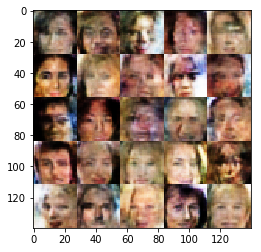

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.1462
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 2.7835
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 2.4598
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 2.4471
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 3.3476


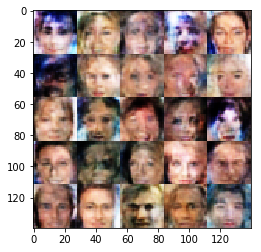

Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 2.2387
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 4.5750
Epoch 1/1... Discriminator Loss: 1.7249... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 2.7384
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.8697
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.8666
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 3.6904
Epoch 1/1... Discriminator Loss: 3.6716... Generator Loss: 4.4095


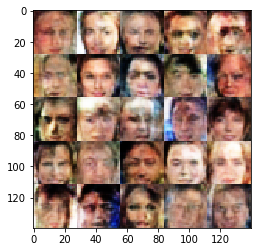

Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 1.6462... Generator Loss: 3.4405
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 2.1218
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 3.6510
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.5353
Epoch 1/1... Discriminator Loss: 2.4728... Generator Loss: 3.8564
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 2.1795
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 2.3568


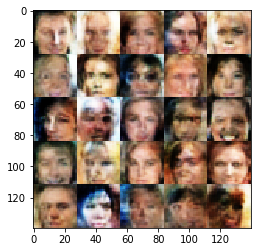

Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 2.5082
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 2.5521
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.8428
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 2.4000
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 3.1268


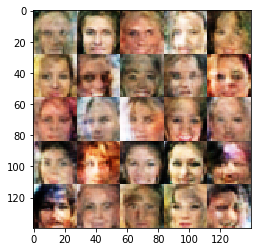

Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 2.2194
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.9803
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 4.4055
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 3.0353
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.4155


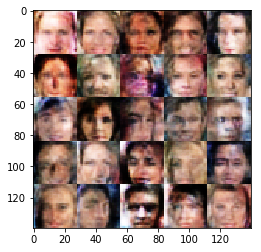

Epoch 1/1... Discriminator Loss: 2.0698... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 2.0412
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.6939
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 2.0052
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 3.2021
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 3.1186
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 3.1047
Epoch 1/1... Discriminator Loss: 1.7433... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.7012


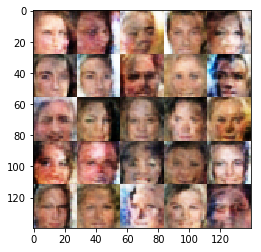

Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 2.5363
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 2.7471
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.7588
Epoch 1/1... Discriminator Loss: 2.1809... Generator Loss: 0.2959
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.9028
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 2.2973
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 2.5850


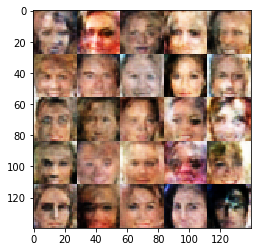

Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 4.5548
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 3.2671
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.8156
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 2.7593
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 2.6192
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 3.2773
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 2.5755
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 3.4058
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.0175


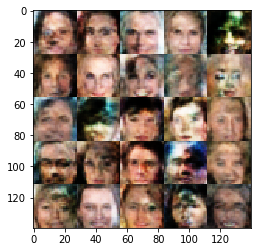

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 2.9086
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 4.1766
Epoch 1/1... Discriminator Loss: 1.7514... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.6777
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 2.5743
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 3.5991
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 3.8640
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 2.1744
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 2.1271
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.1462


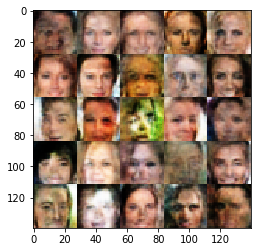

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 3.0000
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 4.2362
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 3.3334
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 2.9255
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 2.6220
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 2.6014
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 3.0864
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 4.1090


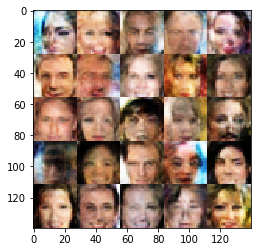

Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.7345
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 3.0362
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 3.3144
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 2.8741
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 2.1541
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 2.3030


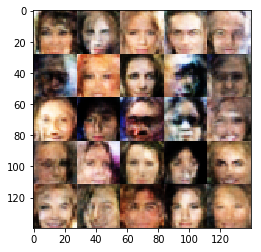

Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 3.0888
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 3.3199
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 3.2057
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.7577
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 3.1937
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 3.4122
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 2.4676
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.9153


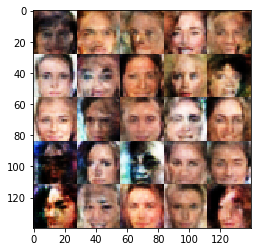

Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 3.5883
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 2.0127
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 3.1073
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 3.6784
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 3.4987
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 2.6094
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 2.8028


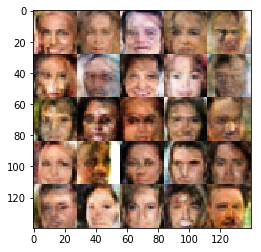

Epoch 1/1... Discriminator Loss: 1.7961... Generator Loss: 3.1393
Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 2.0473
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 2.5892
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 3.2118
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 3.4612
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 2.2502
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 3.4997
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 3.0643
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 2.5235


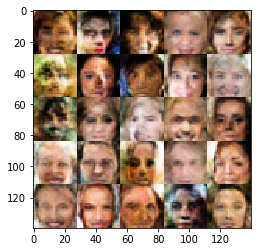

Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 3.9610
Epoch 1/1... Discriminator Loss: 2.0480... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 2.5222
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 2.8486
Epoch 1/1... Discriminator Loss: 1.9042... Generator Loss: 3.5643
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 2.1334
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 2.3486
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.5345


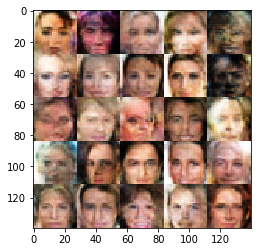

Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 3.2613
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.9059
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 2.6964
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 2.1140
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 3.3157
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 3.1974
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 3.0850
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.8528
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 3.2751


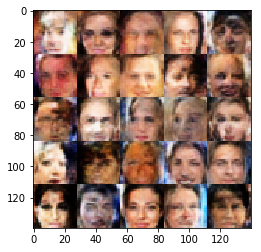

Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 3.2887
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 3.2391
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 2.5990
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 4.9088
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.9557
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 3.1643
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 2.7332
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 3.0340


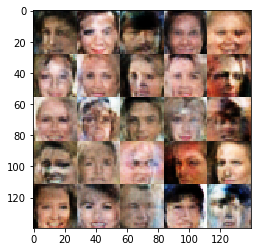

Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 2.3844
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.8486
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 3.4233
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 2.3292
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 2.6321
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 2.5842
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 3.0188


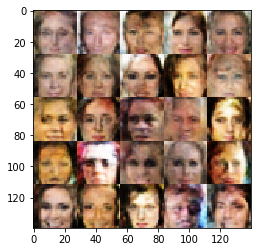

Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 2.7218
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 1.8966
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.8818
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 2.0945
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 3.4739
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 2.7976
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 3.1516
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 2.7552
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.5716


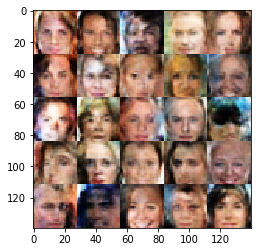

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 3.0862
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.9843
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.6718
Epoch 1/1... Discriminator Loss: 1.9006... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 2.0181
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 2.9566
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.2615
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 2.6288
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.9016


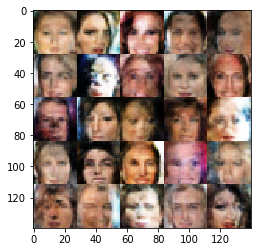

Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 2.5669
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 2.7607
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 2.7348
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 4.5983
Epoch 1/1... Discriminator Loss: 1.6302... Generator Loss: 3.8710
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 2.3103
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 3.6079


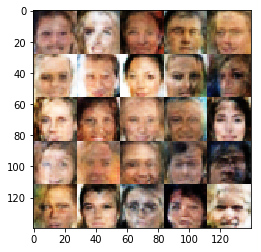

Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 3.9545
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 3.2445
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 3.2170
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 4.6458
Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 3.0352
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 2.6855
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 2.4150


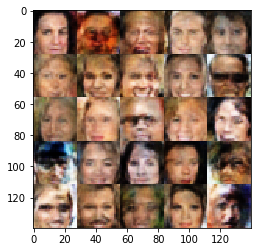

Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 3.1893
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 3.9187
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 2.0160
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 3.7476
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 3.2125
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 2.4555
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 2.1910
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.7814
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 3.6422


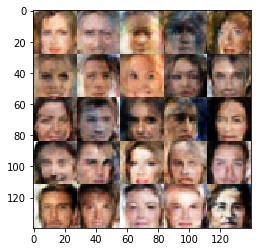

Epoch 1/1... Discriminator Loss: 2.0839... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 2.8159
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 2.7939
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 3.0495
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 1.9580
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 3.0189
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.8092
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.9990


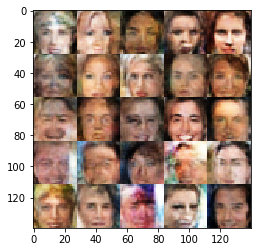

Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 3.7581
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 3.4879
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 2.7298
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 4.5777
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 3.2306
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 3.8101
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 3.0159


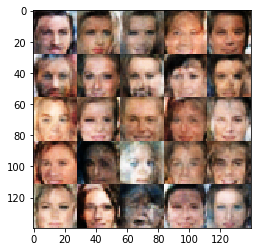

Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 2.5193
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.5598
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.9891
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 2.4743
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 3.4423
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 2.6447
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 3.5295
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 2.9415
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.4299


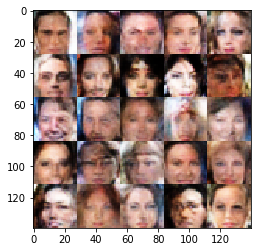

Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 2.2597
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 4.2290
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 4.9385
Epoch 1/1... Discriminator Loss: 2.6451... Generator Loss: 0.1948
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 3.6007
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 2.5075
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 3.7803
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.7447
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9050


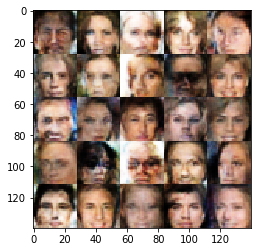

Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 3.3157
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.6892
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 3.2748
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 3.0905
Epoch 1/1... Discriminator Loss: 2.2943... Generator Loss: 0.2935
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.9577
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.9365
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.6194


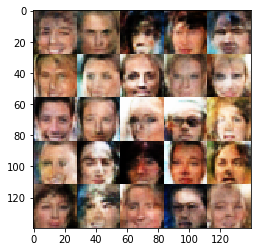

Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.8885
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8114


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.